In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import swifter
from sklearn.model_selection import train_test_split
import re
import nltk
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,LSTM,Conv1D,MaxPool1D,Flatten
import tensorflow as tf

In [2]:
NUM_WORKERS = 8
TEST_SIZE = 0.3
LABEL_COLUMN_NAME = "oh_label"
TEXT_COLUMN_NAME = "Text"
DATASET_PATH = "../Data/ver1.csv"

In [3]:
df= pd.read_csv(DATASET_PATH, index_col=False)
df = df.dropna()
df.drop(["Unnamed: 0", "index"],axis=1, inplace = True)

In [4]:
df["Text"].swifter.apply(len).describe()

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

count    100000.000000
mean        363.608200
std         685.901605
min           1.000000
25%          83.000000
50%         159.000000
75%         369.000000
max       17805.000000
Name: Text, dtype: float64

In [5]:
doc2vec_model = Doc2Vec([TaggedDocument(doc, [i]) for i, doc in enumerate(common_texts)], vector_size=40, window=8, min_count=1, workers=NUM_WORKERS)
stop_words = set(nltk.corpus.stopwords.words("english"))
X = df[TEXT_COLUMN_NAME].swifter.apply(lambda text : doc2vec_model.infer_vector([word for word in nltk.word_tokenize(text) if word not in stop_words]))
y = df[LABEL_COLUMN_NAME]
x_train, x_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=1)

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

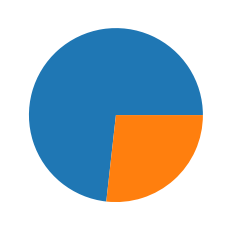

In [14]:
plt.pie(y.value_counts())
weights = (1-y.value_counts()/y.size)*100

In [15]:
weights

0.0    26.771
1.0    73.229
Name: oh_label, dtype: float64

In [26]:
# strategy = tf.distribute.MirroredStrategy()
model = Sequential()
# model.add(Conv1D(40, 5,strides=1, activation='relu',padding="same",input_shape=(1,40)))
model.add(Dense(15, activation="relu",input_shape=(1,40)))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=["accuracy",tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1, 15)             615       
_________________________________________________________________
dense_10 (Dense)             (None, 1, 1)              16        
Total params: 631
Trainable params: 631
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = model.fit(np.expand_dims(np.stack(x_train),axis=1),y_train,batch_size=200,epochs=5000,
                    validation_split=0.05,class_weight=weights.to_dict(),
                    use_multiprocessing=True,workers=NUM_WORKERS,callbacks=[callback])

Epoch 1/5000
333/333 [==============================] - 0s 1ms/step - loss: 27.0500 - accuracy: 0.5250 - recall_4: 0.5501 - precision_4: 0.2933 - val_loss: 0.6920 - val_accuracy: 0.5086 - val_recall_4: 0.5281 - val_precision_4: 0.2864
Epoch 2/5000
333/333 [==============================] - 0s 1ms/step - loss: 27.0485 - accuracy: 0.5309 - recall_4: 0.5397 - precision_4: 0.2945 - val_loss: 0.6972 - val_accuracy: 0.4654 - val_recall_4: 0.6133 - val_precision_4: 0.2824
Epoch 3/5000
333/333 [==============================] - 0s 1ms/step - loss: 27.0425 - accuracy: 0.5266 - recall_4: 0.5492 - precision_4: 0.2940 - val_loss: 0.6914 - val_accuracy: 0.5109 - val_recall_4: 0.5353 - val_precision_4: 0.2893
Epoch 4/5000
333/333 [==============================] - 0s 1ms/step - loss: 27.0407 - accuracy: 0.5215 - recall_4: 0.5646 - precision_4: 0.2944 - val_loss: 0.6843 - val_accuracy: 0.5731 - val_recall_4: 0.3960 - val_precision_4: 0.2944
Epoch 5/5000
333/333 [==============================] - 0s 1

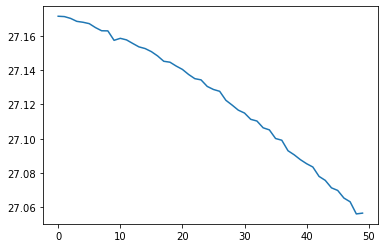

In [28]:
plt.plot(history.history['loss'])

In [ ]:
model = Sequential()
model.add(LSTM(48,input_shape=(79,1),recurrent_dropout=0.5))
model.add(Dense(24, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer='adam',metrics=["accuracy"])
model.summary()